In [44]:
import quandl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use('default')
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import scipy
from datetime import datetime
from scipy.interpolate import interp1d
from cvxopt.glpk import ilp 
from cvxopt import solvers,matrix

#### Import ED data from Quandl

In [2]:
token = "xuGzZkbbnKezcWRj1YcD"# to run enter your token
n = range(1,21)
nms = ["CHRIS/CME_ED"+str(i) for i in n]
dfs = [quandl.get(nm, authtoken=token) for nm in nms]

#### Create a list of ED contracts to be used for analysis

In [3]:
columns = list()
for i in range(0,8):
    name = ('ED'+str(i+1))
    columns.append(name)
columns 

['ED1', 'ED2', 'ED3', 'ED4', 'ED5', 'ED6', 'ED7', 'ED8']

#### Extract Data for required ED series and specified dates

In [4]:
sample = pd.concat([dfs[0]['Settle'],dfs[1]['Settle'], dfs[2]['Settle'],
                    dfs[3]['Settle'], dfs[4]['Settle'], dfs[5]['Settle'], 
                    dfs[6]['Settle'], dfs[7]['Settle']],axis = 1)

sample.index = pd.to_datetime(sample.index)
sample = sample.loc['2004-01-01':]

df = sample.loc['2004-01-01':'2006-12-31']
df.columns = columns

sample1 = df.dropna()

df_1 = sample.loc['2007-01-010':'2007-03-31']
df_1.columns = columns
outofsample = 100 - df_1

#### Sanity Check of the input data before using to identify any distortions

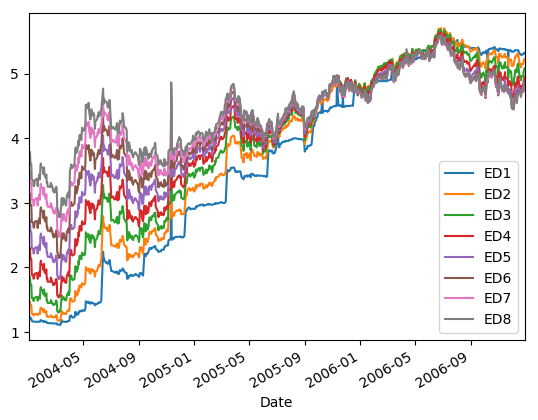

ED1
DatetimeIndex(['2004-06-14', '2004-11-11'], dtype='datetime64[ns]', name='Date', freq=None)
ED2
DatetimeIndex(['2004-06-14', '2004-11-11'], dtype='datetime64[ns]', name='Date', freq=None)
ED3
DatetimeIndex(['2004-06-14', '2004-11-11'], dtype='datetime64[ns]', name='Date', freq=None)
ED4
DatetimeIndex(['2004-06-14', '2004-11-11'], dtype='datetime64[ns]', name='Date', freq=None)
ED5
DatetimeIndex(['2004-11-11'], dtype='datetime64[ns]', name='Date', freq=None)
ED6
DatetimeIndex(['2004-11-11'], dtype='datetime64[ns]', name='Date', freq=None)
ED7
DatetimeIndex(['2004-11-11'], dtype='datetime64[ns]', name='Date', freq=None)
ED8
DatetimeIndex(['2004-11-11'], dtype='datetime64[ns]', name='Date', freq=None)


In [5]:
(100-sample1).plot()
plt.show()

def find_na_dates(df):
    # finds nan's in data
    columns = list(df)
    for i in range(len(columns)):
        print(columns[i])
        ind = df[columns[i]].index[df[columns[i]].apply(np.isnan)]
        print(ind)
def sanity_check(df1,max_allowed_change):
    #takes dataframe as input and returns dates with change greater than specified % between 2 consecutive days
    
    df = df1.diff(periods=1).dropna()
    df1.to_excel('output.xlsx')
    df[df > max_allowed_change] = np.nan
    return find_na_dates(df)
sanity_check(100-sample1,0.5)

### Sanity Check:

On dates 2004-06-14 & 2004-11-11 eurodollar rates spiked, while it may feel like some error in the data. But those two dates were marked by the Fed Policy changes where Fed hiked interest rates by 25 basis points on June 30th 2004 and Nov 10th 2004,
So, I am not adjusting for abnormal changes in the data. Following article provides the refernce about impending changes anticipated by markets and resaoning for out-of-whack realtionship between FFR and EuroDollar Futures.
https://www.realclearmarkets.com/articles/2013/11/22/the_fomc_begins_to_lose_control_of_the_curve_100751.html

### DatasetA : Settle prices of frst 8 rolling Eurodollar futures for dates Jan-2004 through Dec-2006

In [6]:
DatasetA = 100- sample1
DatasetA.head()

,ED1,ED2,ED3,ED4,ED5,ED6,ED7,ED8
Date,,,,,,,,
2004-01-02,1.240,1.495,1.875,2.320,2.740,3.145,3.485,3.790
2004-01-05,1.235,1.475,1.855,2.305,2.740,3.145,3.490,3.790
2004-01-06,1.215,1.420,1.735,2.140,2.565,2.980,3.330,3.630
2004-01-07,1.210,1.415,1.735,2.135,2.555,2.960,3.300,3.590
2004-01-08,1.210,1.415,1.735,2.135,2.550,2.960,3.300,3.595


### Chou Ng CCA Function

In [7]:
def CCA_Chou_Ng(data_set):
    
    #data_set is pandas dataframe
    df_lag = data_set.shift(1).dropna()
    df = data_set.drop(data_set.index[0]).dropna()
    n = len(data_set.columns)
    
    #X(t) ~ M_1 + X(t-1)
    X = df_lag.as_matrix()
    X_I = sm.add_constant(X)
    Y = df.as_matrix()
    l1 = sm.OLS(Y,X_I).fit()
    B=l1.params[1:(n+1)]
    
    #X(t-1) ~ M_2 + X(t)
    Y_I = sm.add_constant(Y)
    l2 = sm.OLS(X,Y_I).fit()
    A=l2.params[1:(n+1)]
    C = np.dot(A,B)
    eig_val, eig_vec = np.linalg.eig(C)
    ascor = np.argsort(eig_val)
    eig_val, eig_vec = eig_val[ascor], eig_vec[:, ascor]
    return eig_val, eig_vec, C

#### List of contract combinations as specified in HW

In [8]:
com = [('ED1', 'ED2'), ('ED1', 'ED3'), ('ED7', 'ED8'), ('ED6', 'ED8')]
com

[('ED1', 'ED2'), ('ED1', 'ED3'), ('ED7', 'ED8'), ('ED6', 'ED8')]

### Step1:
### Problem2 : 1. Use Sample1/DatasetA to construct the 4 WSPR using CCA and/or level regression

In [9]:
weights_ng= []
for i in range(0,4):
    ls = [com[i][0], com[i][1]]
    fly=DatasetA[ls]
    df1 = fly
    n = len(df1.columns)
    val, vec, C = CCA_Chou_Ng(df1)
    vec = pd.DataFrame(vec)
    vec = vec.rename(columns=lambda x: n-x-1, inplace=False)
    w = vec[1].values
    w_cca_cn = np.round([1, w[1]/w[0]],decimals=4)
    weights_ng.append(w_cca_cn)

In [10]:
weights = pd.DataFrame({'Combination': com,'Wt_NgCCA': weights_ng})
weights.set_index('Combination', inplace = True)
add = weights.index.values
weights

,Wt_NgCCA
Combination,
"(ED1, ED2)","[1.0, -1.0765]"
"(ED1, ED3)","[1.0, -1.2148]"
"(ED7, ED8)","[1.0, -1.1932]"
"(ED6, ED8)","[1.0, -1.4657]"


### Step 2:
### Problem 2: 2. Inspect stationarity and compute summary statistics for these 4 WSPRs in Sample1

In [11]:
def adf_test(df):
    adf = adfuller(df)
    y = 'Time Series is stationary'
    n = 'Time series is not stationary'
    if adf[0]<=adf[4]['5%']:
        return [adf[0],adf[4]['5%'],adf[1],y]
    else:
        return [adf[0],adf[4]['5%'],adf[1],n]

In [12]:
WSPR_Ng=[]
for i in range(0,4):
    ret = DatasetA[add[i][0]]*weights['Wt_NgCCA'] [i][0]+ DatasetA[add[i][1]]*weights['Wt_NgCCA'] [i][1]
    WSPR_Ng.append(ret)

In [13]:
WSPR_NgCCA = pd.DataFrame(WSPR_Ng).T
WSPR_NgCCA.columns = com
WSPR_NgCCA.head()

,"(ED1, ED2)","(ED1, ED3)","(ED7, ED8)","(ED6, ED8)"
Date,,,,
2004-01-02,-0.369368,-1.037750,-1.037228,-2.410003
2004-01-05,-0.352837,-1.018454,-1.032228,-2.410003
2004-01-06,-0.313630,-0.892678,-1.001316,-2.340491
2004-01-07,-0.313248,-0.897678,-0.983588,-2.301863
2004-01-08,-0.313248,-0.897678,-0.989554,-2.309192


In [14]:
adf_stat_NgCCA = []
for i in range(0,4):
    t = adf_test(WSPR_NgCCA[com[i]])
    adf_stat_NgCCA.append(t)

In [15]:
header = ['ADF Statistics', 't at 95% CD','p-value','Result']
Stationary_NgCCA = pd.DataFrame(adf_stat_NgCCA)
Stationary_NgCCA.columns = header
Stationary_NgCCA['Combination'] =com
Stationary_NgCCA.set_index('Combination', inplace=True)
Stationary_NgCCA

,ADF Statistics,t at 95% CD,p-value,Result
Combination,,,,
"(ED1, ED2)",-2.438680,-2.865438,0.131115,Time series is not stationary
"(ED1, ED3)",-2.607032,-2.865366,0.091553,Time series is not stationary
"(ED7, ED8)",-2.453348,-2.865366,0.127242,Time series is not stationary
"(ED6, ED8)",-2.383493,-2.865366,0.146450,Time series is not stationary


### Step 3:
### Problem 2: 3. Inspect stationarity and compute summary statistics for these 4 WSPR 3m out-of-sample

In [16]:
WSPR_Ng_out=[]
for i in range(0,4):
    ret_out = outofsample[add[i][0]]*weights['Wt_NgCCA'] [i][0]+ outofsample[add[i][1]]*weights['Wt_NgCCA'] [i][1]
    WSPR_Ng_out.append(ret_out)

In [17]:
WSPR_NgCCA_out = pd.DataFrame(WSPR_Ng_out).T
WSPR_NgCCA_out.columns = com
WSPR_NgCCA_out.head()

,"(ED1, ED2)","(ED1, ED3)","(ED7, ED8)","(ED6, ED8)"
Date,,,,
2007-01-10,-0.311243,-0.860480,-0.934122,-2.231659
2007-01-11,-0.318155,-0.901220,-0.950714,-2.264601
2007-01-12,-0.334302,-0.931590,-0.948442,-2.278230
2007-01-15,-0.345833,-0.951960,-0.956340,-2.275215
2007-01-16,-0.339685,-0.925516,-0.951510,-2.273573


In [18]:
adf_stat_NgCCA_out = []
for i in range(0,4):
    t_out = adf_test(WSPR_NgCCA_out[com[i]])
    adf_stat_NgCCA_out.append(t_out)

In [19]:
header = ['ADF Statistics', 't at 95% CD','p-value','Result']
Stationary_NgCCA_out = pd.DataFrame(adf_stat_NgCCA_out)
Stationary_NgCCA_out.columns = header
Stationary_NgCCA_out['Combination'] =com
Stationary_NgCCA_out.set_index('Combination', inplace=True)
Stationary_NgCCA_out

,ADF Statistics,t at 95% CD,p-value,Result
Combination,,,,
"(ED1, ED2)",-1.130711,-2.913766,0.702671,Time series is not stationary
"(ED1, ED3)",-0.640807,-2.915731,0.861492,Time series is not stationary
"(ED7, ED8)",-1.506242,-2.913766,0.530421,Time series is not stationary
"(ED6, ED8)",-1.371207,-2.913766,0.595999,Time series is not stationary


## Converting Data to Constant Maturity 

#### Read IMM dates CSV file

In [20]:
dates = pd.read_csv('immDate.csv', index_col= 0)
# convert index to date format
dates.index = pd.to_datetime(dates.index)
# convert all columns to date format
dates = dates.apply(pd.to_datetime)

#### Extract Data required for analysis

In [21]:
imm = dates.loc['2004-01-01':]
imm_dates= imm.iloc[:,:8]
imm_dates.head(3)

,ED1,ED2,ED3,ED4,ED5,ED6,ED7,ED8
Date,,,,,,,,
2004-01-02,2004-03-17,2004-06-16,2004-09-15,2004-12-15,2005-03-16,2005-06-15,2005-09-21,2005-12-21
2004-01-05,2004-03-17,2004-06-16,2004-09-15,2004-12-15,2005-03-16,2005-06-15,2005-09-21,2005-12-21
2004-01-06,2004-03-17,2004-06-16,2004-09-15,2004-12-15,2005-03-16,2005-06-15,2005-09-21,2005-12-21


#### Calculation of days to expiry 

In [22]:
# List of index dates
today = list(imm_dates.index)
#Calculation of number of days remaing to expiry for a contract from record date
days_to_expiry = imm_dates.sub(today, axis = 0)
days_to_expiry.head(2)

,ED1,ED2,ED3,ED4,ED5,ED6,ED7,ED8
Date,,,,,,,,
2004-01-02,75 days,166 days,257 days,348 days,439 days,530 days,628 days,719 days
2004-01-05,72 days,163 days,254 days,345 days,436 days,527 days,625 days,716 days


#### Create List of Days in contract for Constant Maturity Interpolation

In [23]:
days_in_contract = np.arange(90.0,90.0 * (len(list(DatasetA))+1),90.0)
days_in_contract

array([  90.,  180.,  270.,  360.,  450.,  540.,  630.,  720.])

#### Interpolation calculation using days to expiry and futures rate for days in contract

In [43]:
cmt = []
for i in range(len(today)):
    #extract days as interger
    x = days_to_expiry.ix[today[i].date()].astype('timedelta64[D]')
    #extract rates for EDs on perticular date
    y = sample.ix[today[i].date()]
    
    #interpolation using interp1d function
    f = interp1d(x,y,fill_value = 'extrapolate')
    c = f(days_in_contract)
    #list of Constant Maturity ED term structure
    cmt.append(c)

#### Convert List of CM Yeilds in presentable Data frame

In [25]:
CMT = pd.DataFrame(cmt)
CMT.index= today
CMT.columns = columns
CMT.index.names = ['Date']
DB = CMT.loc['2004-01-01':'2006-12-31']
DB = DB.dropna()
DatasetB = 100 - DB
DatasetB.head()

,ED1,ED2,ED3,ED4,ED5,ED6,ED7,ED8
Date,,,,,,,,
2004-01-02,1.282033,1.553462,1.938571,2.375385,2.788956,3.179694,3.491703,3.793352
2004-01-05,1.282473,1.545989,1.934121,2.376703,2.802308,3.190765,3.506484,3.803187
2004-01-06,1.257802,1.482308,1.810659,2.214725,2.633407,3.030000,3.349780,3.646484
2004-01-07,1.255055,1.481813,1.814121,2.213462,2.626209,3.012041,3.322308,3.609121
2004-01-08,1.257308,1.485330,1.818516,2.217088,2.626593,3.015510,3.325934,3.617692


#### Visualize the effect of Constant Maturity Adjustment

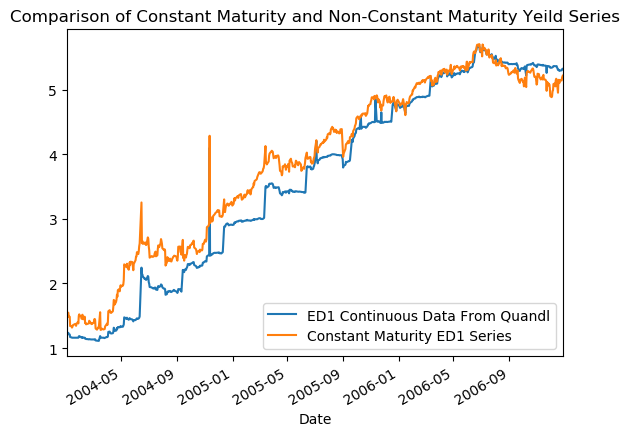

In [26]:
DatasetA['ED1'].plot(label = 'ED1 Continuous Data From Quandl')
DatasetB['ED2'].plot(label ='Constant Maturity ED1 Series')
plt.title('Comparison of Constant Maturity and Non-Constant Maturity Yeild Series')
plt.legend(loc = 4)
plt.show()

##### The graphs above clearly demonstrate the effect of using Constant Maturity adjustment to the data. The blue curve which is ED1 continous series downloaded directly from quandl has steps due to rolling of contract from one maturity to another maturity. While the Constant Maturity Data Clearly eliminates that feature of the data as expected.

### Step 1: For Constant Maturity Series

In [27]:
weights_ng_CMT= []
for i in range(0,4):
    ls = [com[i][0], com[i][1]]
    fly=DatasetB[ls]
    df1 = fly
    n = len(df1.columns)
    val, vec, C = CCA_Chou_Ng(df1)
    vec = pd.DataFrame(vec)
    vec = vec.rename(columns=lambda x: n-x-1, inplace=False)
    w = vec[1].values
    w_cca_cn = np.round([1, w[1]/w[0]],decimals=4)
    weights_ng_CMT.append(w_cca_cn)

In [28]:
weights_CMT = pd.DataFrame({'Combination': com,'Wt_NgCCA_CMT': weights_ng_CMT})
weights_CMT.set_index('Combination', inplace = True)
add = weights_CMT.index.values
weights_CMT

,Wt_NgCCA_CMT
Combination,
"(ED1, ED2)","[1.0, -1.0999]"
"(ED1, ED3)","[1.0, -1.2666]"
"(ED7, ED8)","[1.0, -1.2145]"
"(ED6, ED8)","[1.0, -1.4837]"


In [29]:
WSPR_Ng_CMT=[]
for i in range(0,4):
    ret = DatasetB[add[i][0]]*weights_CMT['Wt_NgCCA_CMT'] [i][0]+ DatasetB[add[i][1]]*weights_CMT['Wt_NgCCA_CMT'] [i][1]
    WSPR_Ng_CMT.append(ret)

In [30]:
WSPR_NgCCA_CMT = pd.DataFrame(WSPR_Ng_CMT).T
WSPR_NgCCA_CMT.columns = com
WSPR_NgCCA_CMT.head()

,"(ED1, ED2)","(ED1, ED3)","(ED7, ED8)","(ED6, ED8)"
Date,,,,
2004-01-02,-0.426619,-1.173362,-1.115322,-2.448502
2004-01-05,-0.417961,-1.167285,-1.112487,-2.452023
2004-01-06,-0.372588,-1.035579,-1.078874,-2.380288
2004-01-07,-0.374791,-1.042711,-1.060970,-2.342812
2004-01-08,-0.376406,-1.046025,-1.067753,-2.352060


### Step 2: For Constant Maturity Series

In [31]:
adf_stat_NgCCA_CMT = []
for i in range(0,4):
    t = adf_test(WSPR_NgCCA_CMT[com[i]])
    adf_stat_NgCCA_CMT.append(t)

In [32]:
header = ['ADF Statistics', 't at 95% CD','p-value','Result']
Stationary_NgCCA_CMT = pd.DataFrame(adf_stat_NgCCA_CMT)
Stationary_NgCCA_CMT.columns = header
Stationary_NgCCA_CMT['Combination'] =com
Stationary_NgCCA_CMT.set_index('Combination', inplace=True)
Stationary_NgCCA_CMT

,ADF Statistics,t at 95% CD,p-value,Result
Combination,,,,
"(ED1, ED2)",-2.530081,-2.865366,0.108326,Time series is not stationary
"(ED1, ED3)",-2.531168,-2.865366,0.108074,Time series is not stationary
"(ED7, ED8)",-2.401545,-2.865366,0.141301,Time series is not stationary
"(ED6, ED8)",-2.310212,-2.865366,0.168696,Time series is not stationary


### Step 3: For Constant Maturity Series

In [33]:
outofsample_CMT = 100 -CMT.loc['2007-01-010':'2007-03-31']
WSPR_Ng_CMT_out=[]
for i in range(0,4):
    ret = outofsample_CMT[add[i][0]]*weights_CMT['Wt_NgCCA_CMT'] [i][0]+outofsample_CMT[add[i][1]]*weights_CMT['Wt_NgCCA_CMT'] [i][1]
    WSPR_Ng_CMT_out.append(ret)

In [34]:
WSPR_NgCCA_CMT_out = pd.DataFrame(WSPR_Ng_CMT_out).T
WSPR_NgCCA_CMT_out.columns = com
WSPR_NgCCA_CMT_out.head()

,"(ED1, ED2)","(ED1, ED3)","(ED7, ED8)","(ED6, ED8)"
Date,,,,
2007-01-10,-0.420457,-1.110618,-1.037107,-2.321986
2007-01-11,-0.432080,-1.154549,-1.055088,-2.357369
2007-01-12,-0.446974,-1.184565,-1.053436,-2.368639
2007-01-15,-0.455994,-1.200989,-1.061775,-2.370908
2007-01-16,-0.445782,-1.170137,-1.056412,-2.366838


In [35]:
adf_stat_NgCCA_CMT_out = []
for i in range(0,4):
    t_out = adf_test(WSPR_NgCCA_CMT_out[com[i]])
    adf_stat_NgCCA_CMT_out.append(t_out)

In [36]:
header = ['ADF Statistics', 't at 95% CD','p-value','Result']
Stationary_NgCCA_CMT_out = pd.DataFrame(adf_stat_NgCCA_CMT_out)
Stationary_NgCCA_CMT_out.columns = header
Stationary_NgCCA_CMT_out['Combination'] =com
Stationary_NgCCA_CMT_out.set_index('Combination', inplace=True)
Stationary_NgCCA_CMT_out

,ADF Statistics,t at 95% CD,p-value,Result
Combination,,,,
"(ED1, ED2)",-0.990437,-2.913766,0.756736,Time series is not stationary
"(ED1, ED3)",-0.550353,-2.915731,0.881810,Time series is not stationary
"(ED7, ED8)",-1.444858,-2.913766,0.560592,Time series is not stationary
"(ED6, ED8)",-1.395779,-2.913766,0.584298,Time series is not stationary


### Summary of Results:

In [37]:
Result_InSample =pd.concat([weights, Stationary_NgCCA['p-value'],Stationary_NgCCA['Result'], 
           weights_CMT, Stationary_NgCCA_CMT['p-value'],Stationary_NgCCA_CMT['Result']], axis=1)

#### In-Sample Result Comparison between Non-Constant Maturity and Constant Maturity Analysis:

In [38]:
Result_InSample

,Wt_NgCCA,p-value,Result,Wt_NgCCA_CMT,p-value,Result
Combination,,,,,,
"(ED1, ED2)","[1.0, -1.0765]",0.131115,Time series is not stationary,"[1.0, -1.0999]",0.108326,Time series is not stationary
"(ED1, ED3)","[1.0, -1.2148]",0.091553,Time series is not stationary,"[1.0, -1.2666]",0.108074,Time series is not stationary
"(ED7, ED8)","[1.0, -1.1932]",0.127242,Time series is not stationary,"[1.0, -1.2145]",0.141301,Time series is not stationary
"(ED6, ED8)","[1.0, -1.4657]",0.146450,Time series is not stationary,"[1.0, -1.4837]",0.168696,Time series is not stationary


In [39]:
Result_OutSample =pd.concat([weights, Stationary_NgCCA_out['p-value'],Stationary_NgCCA_out['Result'], 
           weights_CMT, Stationary_NgCCA_CMT_out['p-value'],Stationary_NgCCA_CMT_out['Result']], axis=1)

#### Out-of-Sample Result Comparison between Non-Constant Maturity and Constant Maturity Analysis:

In [40]:
Result_OutSample

,Wt_NgCCA,p-value,Result,Wt_NgCCA_CMT,p-value,Result
Combination,,,,,,
"(ED1, ED2)","[1.0, -1.0765]",0.702671,Time series is not stationary,"[1.0, -1.0999]",0.756736,Time series is not stationary
"(ED1, ED3)","[1.0, -1.2148]",0.861492,Time series is not stationary,"[1.0, -1.2666]",0.881810,Time series is not stationary
"(ED7, ED8)","[1.0, -1.1932]",0.530421,Time series is not stationary,"[1.0, -1.2145]",0.560592,Time series is not stationary
"(ED6, ED8)","[1.0, -1.4657]",0.595999,Time series is not stationary,"[1.0, -1.4837]",0.584298,Time series is not stationary


#### Comparison of Results for CM and Non-CM data series:

As we can see the above perticular combination of spread contracts for constant maturity data series and non-constant maturity series are similar. In the last assignment we had few combinations which were stationary, but these selected combinations does not show siginificat improvement inspite of using constant maturity series of futures rates.

### Problem 3 
#### Use the inside market data in Figure 1. to setup an ILP to solve for the best price to sell a butterfly [H8-U8-H9] (note that there are 2 contracts on the belly of the butterfly). 

###### Extra credit: Solve this problem using one of the open-source python packages (cvxopt, lpsolve, Xpress are some of the many options available)

In [89]:
# C.Trasnpose Vector
price = [9966.5, 9962.5, 9957.5, 9954, 4.5, 5.5, 8.5, 4, 9966, 9962, 9957, 9953.5, 4, 5, 8, 3.5 ]

contract_list = ['H8', 'U8', 'H9', 'M9', '(H8-U8)', '(U8-H9)', '(U8-M9)', '(H9-M9)', '-H8', '-U8', '-H9', '-M9', '-(H8-U8)', '-(U8-H9)', '-(U8-M9)', '-(H9-M9)']
# Definning A vector
spr = [[1, 0, 0, 0], [-1, 1, 1, 0], [0, -1, 0, 1],[0, 0, -1, -1]]
spr = np.array(spr)
H = np.hstack((np.eye(4),spr))
A = np.hstack((H,-H))

# Defining B vecotor
b = [-1, 2, -1, 0]
b =np.array(b).astype('float')

h = [468, 2337, 601, 665, 4266, 8355, 41, 46827, 8689, 6396, 2864, 3558, 52, 1201, 1698, 311]
h = np.array(h).astype('float')
G = np.eye(16)

# objective Function  
c = matrix(price, tc = 'd')


# inequality constrains
G = matrix(G,tc ='d')
h = matrix(h, tc ='d')

# equality constraints
A = matrix(A,tc='d')
b = matrix(b, tc ='d')


I = set([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
B = set([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
sol, x= ilp(c = c, G = G, h = h, A =A, b = b,I = I,B = B)
# np.set_printoptions(formatter={'float_kind':'{:f}'.format})
x = np.array(x).astype('int')

In [90]:
optimal_selection =pd.DataFrame(columns = ['# of Contracts','Price'],index =contract_list)
optimal_selection['# of Contracts'] = x
optimal_selection['Price'] = price
optimal_selection

,# of Contracts,Price
H8,0,9966.5
U8,0,9962.5
H9,0,9957.5
M9,0,9954.0
(H8-U8),0,4.5
(U8-H9),1,5.5
(U8-M9),0,8.5
(H9-M9),0,4.0
-H8,0,9966.0
-U8,0,9962.0


In [86]:
butterfly = x.T * np.array(price)
butterfly_cost = butterfly[0][5] - butterfly[0][12]
print('Cost to short butterfly H8-U8-H9 is :', butterfly_cost)

Cost to short butterfly H8-U8-H9 is : 1.5


#### From above table it is clear that we need to buy U8-H9 spread and sell short H8-U9 spread to take short position in a Butterfly [H8-U8-H9] by paying 1.5 dollars